## Modelling Shear Wave Velocity Changes

This notebook includes the code used to generate Figures 4, 5 and 7 in the following manuscript:
- Advanced monitoring of tailings dam performance using seismic noise and stress models
- Authors: Susanne Ouellet, Jan Dettmer, Gerrit Olivier, Tjaart deWit, and Matthew Lato
- Pre-print available at: https://www.researchsquare.com/article/rs-1647118/v1
- corresponding author: Susanne Ouellet, susanne.ouellet2@ucalgary.ca

In [1]:
#Import necessary packages
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
import warnings
import bootstrap as bs
from scipy.optimize import curve_fit
from scipy import stats

In [2]:
def vs_avg_model(pp_data,z,alpha,beta):

    # unit weights of materials (kN/m3)
    g1=22 # bulk unit weight of compacted tailings at 50% Sr (kN/m3)
    g1sat=24 # saturated unit weight of compacted tailings (kN/m3)
    g2=20.5 # saturated unit weight of tailings (kN/m3)
    g3=17 # saturated unit weight of GLU clay (kN/m3) --> Table 10, 2017/18 SI Report
    g_h20=9.81 # unit weight of water (kN/m3)
    g=[g1,g1sat,g2,g3,g_h20]
    
    el=341  # dam crest elevation (m)
    h1 = 8.5 # approximate depth to compacted tailings (dam fill) (m) from dam crest elevation
    h2 = 34 # approximate depth to underlying clay (m) from dam crest elevation
    h3 = 39 # approximate depth to bedrock (m) from dam crest elevation
    nsamples=len(pp_data)
    
    # Initialize arrays 
    vs_model=np.zeros((nsamples))
    sigma_vp=np.zeros((nsamples))

    for l in range(nsamples):
        pp_el=pp_data[l]
        sigma_vp[l]=Stress_model(pp_el,el,h1,h2,h3,z,g)
        vs=alpha*sigma_vp[l]**beta
        vs_model[l]=vs
    vs_avg=np.mean(vs_model[:])         # calculate the mean Vs for alpha, z over nsamples 41 day period)
    return vs_avg,vs_model

def Stress_model(pp_data,el,h1,h2,h3,z,g):
    '''
    pp_data - 1 sample of pond station data
    baro - barometer data in equivalent mH20
    el = elevation of tailings dam crest
    h1= height of upper layer
    g=[g1,g1sat,g2], where g1 = unit weight moist dam fill,g1sat = saturated dam fill, g2 = saturated tailings

    '''
    g1=g[0] # 
    g1sat=g[1]
    g2=g[2]
    g3=g[3]
    g_h20=g[4]
    
    sigma_vp=0 #initialize value
    
    # calculate stresses (assuming that z > pond_depth)
    pond_depth=el-pp_data                       # depth to inferred gwl based on nearby pond, relative to dam crest elevation
    pwp=(z-pond_depth)*g_h20                     # pore water pressure u, where u = gamma_h20 * hw
    if z < pond_depth:
        sigma_t=z*g1
        sigma_vp=sigma_t                         # model does not account for negative pore pressures above inferred gwl 
        
    elif pond_depth <= z <= h1:                  # z is saturated, within compacted tailings (fill)
        sigma_t=pond_depth*g1+(z-pond_depth)*g1sat
        sigma_vp=sigma_t-pwp                   # modelled effective vertical stress (sigma v prime)

    elif z > h1 and z <= h2:                                        # z is saturated, within tailings (beneath filL)
        sigma_t=pond_depth*g1+(h1-pond_depth)*g1sat+(z-h1)*g2
        sigma_vp=sigma_t-pwp
    
    elif z > h2 and z <= h3:             # z is in GLU unit
        sigma_t=pond_depth*g1 + (h1-pond_depth)*g1sat + ((h2-h1)*g2) + (z-h1+h2)*g3
        sigma_vp=sigma_t-pwp

    return sigma_vp

def power_law(x, a, b):
    ''' 
    function to calculate the power-law with constants a and b, power regression 
    https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509
    '''
    return a*np.power(x,b)

def get_ecdf(data):
    """Returns x,y for ecdf
    https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d
    """
    # Get lenght of the data into n
    n = len(data)
    
    # We need to sort the data
    x = np.sort(data)
    
    # the function will show us cumulative percentages of corresponding data points
    y = np.arange(1,n+1)/n
    
    return x,y

def get_abmc(alpha_boot,beta_boot):
    # alpha
    x_a,y_a=bs.get_ecdf(alpha_boot)
    randa=np.random.choice(y_a)
    inda=np.where(y_a==randa)
    alpha_mc=x_a[inda]
    # beta
    x_b,y_b=bs.get_ecdf(beta_boot)
    randb=np.random.choice(y_b)
    indb=np.where(y_b==randb)
    beta_mc=x_b[indb]

    return alpha_mc,beta_mc


In [3]:
#input parameters
ista=0                                                        # set index at 0
nsta=25                                                       # number of stations
mdays=60*86400                                                # max 60 days shown for plotting, as dvv pickle files have 60 samples 

##############################
## STRESS MODEL INPUTS #######
##############################

# unit weights of materials (kN/m3)
g1=22 # bulk unit weight of compacted tailings at 50% Sr (kN/m3) --> Table 10, 2017/18 SI Report
g1sat=24 # saturated unit weight of compacted tailings (kN/m3) --> Table 10, 2017/18 SI Report
g2=20.5 # saturated unit weight of tailings (kN/m3) --> Table 10, 2017/18 SI Report
g3=17 # saturated unit weight of GLU clay (kN/m3) --> Table 10, 2017/18 SI Report
g_h20=9.81 # unit weight of water (kN/m3)
g=[g1,g1sat,g2,g3,g_h20]

#geometry inputs
el=341  # dam crest elevation (m)
h1 = 8.5 # approximate depth to compacted tailings (dam fill) (m) from dam crest elevation
h2 = 34 # approximate depth to underlying clay (m) from dam crest elevation
h3 = 39 # approximate depth to bedrock (m) from dam crest elevation

# date for plotting
date = np.array('2020-06-18 01:30:00', dtype=np.datetime64)   # review ambient-noise-processing.ipynb, showing that all data trimmed from june 18 00:00 to 03:00
datevec=date+np.arange(0,mdays,86400)                         # np.arange used to create date vector, sampling once per 24-hour period.
datevectr=np.delete(datevec,[0,1,2,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13]) #trim from June 18 to June 21, from Aug 3 to 15)

#tailings pond station data
pp_station=pd.read_csv('pp_station.csv',parse_dates=["Time"],index_col=["Time"])       # baro, surface temp (in datalogger enclosure), pond sensor temp, pond sensor level from 2020-06 to 2020-09
pp_daily=pp_station.resample('1D',offset='1h30min').mean()    #resample dataset in pandas by taking the daily mean
pp_daily=pp_daily[21:65]                                      # trim pond data to dvv extents, June 21 01:30 to Aug 03 01:30
pp_data=pp_daily.iloc[:,3].values                             # pond level data (in m)
nsamples=len(pp_data)

#sCPT data, used for regression analyses load
scpt_all=pd.read_csv('vs_scpt_2017-18.csv')

# FILTER SCPT DATA BY MATERIAL TYPE (TAILINGS, COARSE & COMPACTED TAILINGS, GLU (CLAY))
scpt_tails=scpt_all[(scpt_all.material_type == "Fine Mill Tailing")]
scpt_compcoar=scpt_all[(scpt_all.material_type == "Coarse Mill Tailings") | (scpt_all.material_type == "Compacted Tailings")]
scpt_glu=scpt_all[(scpt_all.material_type == "Glaciolacustrine")]

# convert pandas data frame to numpy array for regression analyses & plotting
tails_arr = scpt_tails.to_numpy()
compcoar_arr=scpt_compcoar.to_numpy()
glu_arr = scpt_glu.to_numpy()


## DV/V DATA LOAD ############
# load pickle files containing dvv information
dvvavg_caus_pkldata=glob.glob("dvv-avg-causal*.pickle")
dvvavg_acaus_pkldata=glob.glob("dvv-avg-acausal*.pickle")

for ifile in range(nsta):
    #causal data -> coda window from 0.5 to 3.5 sec
    with open(dvvavg_caus_pkldata[ifile],'rb') as f:
        dv_avg_causal=pickle.load(f)
    #acausal data -> coda window from -3.5 to -0.5 sec
    with open(dvvavg_acaus_pkldata[ifile],'rb') as f:
        dv_avg_acausal=pickle.load(f)
    dv_avg=ma.masked_equal(np.nanmean((dv_avg_causal,dv_avg_acausal),axis=0),0)
    ista+=1

dv_avgtr = np.delete(dv_avg,[0,1,2,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13],axis=1) # trim array to dvv extents
dv_avg_tot=np.nanmean(dv_avgtr[:],axis=0)            # average dv/v (%) measurements over geophone array

# define arrays for minimum dvv and max dvv, for plotting purposes
dv_avgmin=np.zeros(len(datevectr))
dv_avgmax=np.zeros(len(datevectr))

for i in range(len(datevectr)):
    dv_avgmin[i]=np.nanmin(dv_avgtr[:,i]) # minimum dvv array
    dv_avgmax[i]=np.nanmax(dv_avgtr[:,i]) # maximum dvv array

# load CC pickle file for scatter plot
with open('cc_avg_tot.pickle','rb') as f:
    cc_avg_tot=pickle.load(f)
cc_avg=np.delete(cc_avg_tot,[0,1,2,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13],axis=0) # trim array to dvv extents



<ipython-input-3-2d63f284f5e9>:62: RuntimeWarning: Mean of empty slice
  dv_avg=ma.masked_equal(np.nanmean((dv_avg_causal,dv_avg_acausal),axis=0),0)


In [7]:
print(len(tails_arr),len(compcoar_arr),len(glu_arr)) # count individual scpt samples in each unit

415 175 117


In [ ]:
############################################################################
############################ BOOTSTRAP #####################################
### CAREFUL - n_boot = 150,000 takes ~1.5 TO 1.75 hours to run #############
############################################################################

# tailings alpha, beta from bootstrap
n_boot=150000 # number bootstrap simulations to run (eventually get to 150000) 

alpha_boot_t, beta_boot_t = bs.bootstrap(tails_arr,n_boot,"Tailings")
alpha_boot_cc, beta_boot_cc = bs.bootstrap(compcoar_arr,n_boot,"Compacted & Coarse Tailings")
alpha_boot_glu, beta_boot_glu = bs.bootstrap(glu_arr,n_boot,"Glaciolacustrine Clay")

In [ ]:
# print mean values of alpha, beta parameters for tailings, dam fill and clay units obtained from bootstrap
print(a_t,b_t,a_cc,b_cc,a_glu,b_glu) 

In [507]:
##################################################################################################################
### MONTE CARLO SIMULATIONS FOR DVsVs ###### #####################################################################
##################################################################################################################
# CAREFUL !!! THIS TAKES ~8 HOURS TO RUN WITH NITER = 50,000 #####################################################
# start time at ~6:30 AM finished at 2:00 pm (around) (niter=50,000)##############################################
##################################################################################################################
# take 2 after creating lists of alpha, beta to store. start at 3:13 pm ###


z=np.arange(1,39,0.1)
shapez=len(z)
niter = 50000

dVsVs_MC=np.zeros((niter,shapez,nsamples))
misfit1=np.zeros((niter,shapez))
misfit2=np.zeros((niter,shapez))

a_tarr=[]
b_tarr=[]
a_ccarr=[]
b_ccarr=[]
a_gluarr=[]
b_gluarr=[]

for _ in range(niter):
    
    ## DRAW RANDOM ALPHA, BETA PARAMETERS FROM ECDF DISTRIBUTION (via BOOTSTRAP)
    a_mc_t,b_mc_t=get_abmc(alpha_boot_t,beta_boot_t)            # draw alpha, beta from tailings
    a_mc_cc,b_mc_cc=get_abmc(alpha_boot_cc,beta_boot_cc)        # draw alpha, beta from compacted / coarse tailings
    a_mc_glu,b_mc_glu=get_abmc(alpha_boot_glu,beta_boot_glu)    # draw alpha, beta from glaciolacustrine clay

    # create lists of drawn alpha, beta parameters for review
    a_tarr.append(a_mc_t)
    b_tarr.append(b_mc_t)
    a_ccarr.append(a_mc_cc)
    b_ccarr.append(b_mc_cc)
    a_gluarr.append(a_mc_glu)
    b_gluarr.append(b_mc_glu)

    for i in range(shapez):
        if z[i] <= h1:                        # z is saturated, within compacted tailings (fill) / coarse tailings
            # use average Vs from above to calculate dVs/Vs
            vs_avg,vs_model=vs_avg_model(pp_data,z[i],a_mc_cc,b_mc_cc)
        elif z[i] > h1 and z[i] <= h2:             # z is in fine tailings unit
            vs_avg,vs_model=vs_avg_model(pp_data,z[i],a_mc_t,b_mc_t)
        elif z[i] > h2 and z[i] <= h3:             # z is GLU unit
            vs_avg,vs_model=vs_avg_model(pp_data,z[i],a_mc_glu,b_mc_glu)
        else:
            print(h1,h2,h3,z[i], "Error. Depth z entered is greater than bedrock depth. Vs model does not apply.")
        dVsVs_MC[_,i,:]=100*(vs_model-vs_avg)/vs_avg # multiply by 100 to express as a percentage

    ############ MISFIT ###################

    for i in range(shapez):
        misfit1[_,i]=np.nansum(np.abs(dv_avg_tot[:]-dVsVs_MC[_,i,:]))
        misfit2[_,i]=np.nansum((dv_avg_tot[:]-dVsVs_MC[_,i,:])**2)


In [508]:
print(_,niter,shapez)

49999 50000 380


In [514]:
# for each Monte Carlo iteration, find minimum z. Then plot min. z in histogram plot to get 95% confidence intervals.
# also map the minimum z depth index over to dVsVs, for plotting purposes. 

ndays=len(datevectr)
dVsVs_minz=np.zeros((niter,ndays))
minz=[]
ind=[]
for i in range(niter): # replace with  niter
    #misfit_minz=np.nanmin(misfit1[i,:])
    ind1 = np.unravel_index(np.nanargmin(misfit1[i,:], axis=None), misfit1[i,:].shape)
    ind.append(ind1)
    minz.append(z[ind1])
    dVsVs_minz[i,:]=dVsVs_MC[i,ind1,:]
    print("Iteration: ",i,ind1,z[ind1])

Iteration:  0 (147,) 15.700000000000014
Iteration:  1 (155,) 16.500000000000014
Iteration:  2 (146,) 15.600000000000012
Iteration:  3 (146,) 15.600000000000012
Iteration:  4 (149,) 15.900000000000013
Iteration:  5 (142,) 15.200000000000014
Iteration:  6 (146,) 15.600000000000012
Iteration:  7 (151,) 16.100000000000016
Iteration:  8 (149,) 15.900000000000013
Iteration:  9 (146,) 15.600000000000012
Iteration:  10 (132,) 14.200000000000012
Iteration:  11 (161,) 17.100000000000016
Iteration:  12 (154,) 16.400000000000013
Iteration:  13 (152,) 16.200000000000014
Iteration:  14 (144,) 15.400000000000013
Iteration:  15 (147,) 15.700000000000014
Iteration:  16 (145,) 15.500000000000012
Iteration:  17 (139,) 14.900000000000013
Iteration:  18 (147,) 15.700000000000014
Iteration:  19 (152,) 16.200000000000014
Iteration:  20 (149,) 15.900000000000013
Iteration:  21 (149,) 15.900000000000013
Iteration:  22 (145,) 15.500000000000012
Iteration:  23 (157,) 16.700000000000014
Iteration:  24 (151,) 16.1

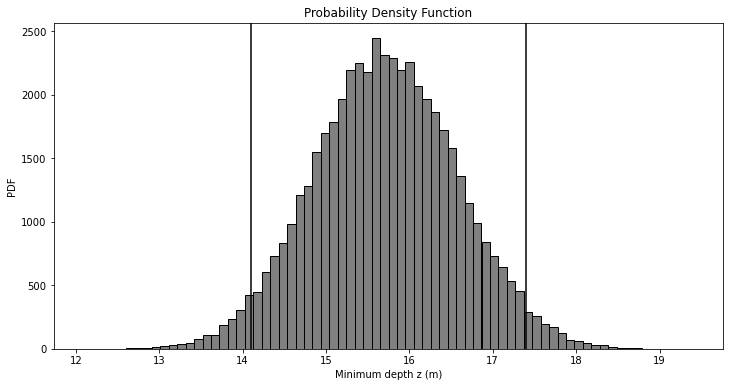

In [265]:
# plot histogram of alpha, beta obtained from bootstrap sampling
plt.rcParams["figure.figsize"]=(12,6)
nbins=72 # number of bins used in histogram

# plot alpha histogram
plt.hist(minz,bins=nbins,color='gray',edgecolor='black')
# Showing the related percentiles
plt.axvline(x=np.percentile(minz,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='k')
plt.axvline(x=np.percentile(minz,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='k')
plt.xlabel("Minimum depth z (m)")
plt.ylabel("PDF")
plt.title("Probability Density Function")
plt.show()


In [447]:
temp=find_nearest(sorted(minz),np.mean(minz)) # list must be sorted for this function
print("nearest value is: ", temp)
print("mean value of array is: ",np.mean(minz))
minz_ind=np.where(minz==temp)
print("median is: ",np.median(minz))
print("mode is: ", stats.mode(minz))
print("standard deviation is: ", np.std(minz))
test1=np.percentile(minz,[2.5])
test2=np.percentile(minz,[97.5])
print("95% confidence intervals are: ",test1,test2)

nearest value is:  15.700000000000014
mean value of array is:  15.710078000000012
median is:  15.700000000000014
mode is:  ModeResult(mode=array([15.6]), count=array([2445]))
standard deviation is:  0.8450222682959315
95% confidence intervals are:  [14.1] [17.4]


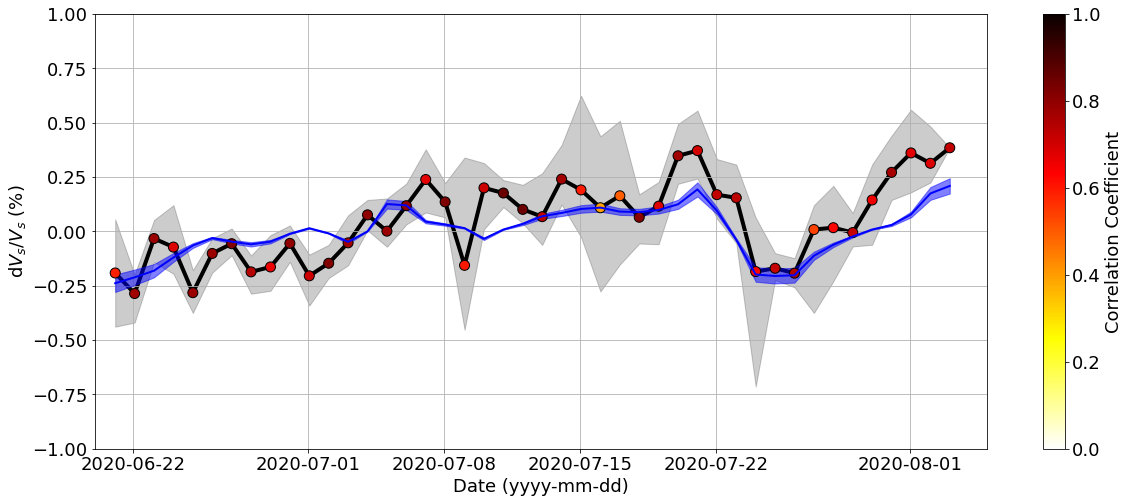

In [520]:
fsize=18                                    # set font size to 18
plt.rcParams["figure.figsize"]=(20,8)
fig,(ax1)=plt.subplots(nrows=1, ncols=1,sharex=True)

dv_avg_tot=np.nanmean(dv_avgtr[:],axis=0)
dVsVs_min=np.zeros(len(datevectr))
dVsVs_max=np.zeros(len(datevectr))
dVsVs_mean=np.zeros(len(datevectr))

for i in range(ndays):
    dVsVs_min[i]=np.min(dVsVs_MC[:,ind[i],i]) # minimum dVsVs array
    dVsVs_max[i]=np.max(dVsVs_MC[:,ind[i],i]) # maximum dVsVs array
    dVsVs_mean[i]=np.mean(dVsVs_MC[:,ind[i],i]) #mean dVsVs array
# #Monte Carlo method of min, max dVsVs
ax1.fill_between(datevectr,dVsVs_min,dVsVs_max,color='b',alpha=0.5,linewidth=1,zorder=2)
ax1.plot(datevectr,dVsVs_mean,color='b',linewidth=2,zorder=3)

# dvv estimates
ax1.plot(datevectr,dv_avg_tot,'-k',zorder=1,linewidth=4,label='Average dv/v (%) measurements over geophone array')
ax1.fill_between(datevectr, dv_avgmin, dv_avgmax,color='k',alpha=0.2)

ax1.set_ylim(-1,1)
ax1.set_ylabel("d$V_s$/$V_s$ (%)",fontsize=fsize)
ax1.set_xlabel("Date (yyyy-mm-dd)",fontsize=fsize)
ax1.set_xlim('2020-06-20','2020-08-05')
#ax1.legend(fontsize=fsize,loc=2)
ax1.tick_params(axis='x', labelsize=fsize) 
ax1.tick_params(axis='y', labelsize=fsize) 

sp=ax1.scatter(x=datevectr,y=dv_avg_tot,s=100,zorder=3,c=cc_avg,cmap='hot_r',edgecolors='k',vmin=0,vmax=1) 
cbar=plt.colorbar(sp)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(label='Correlation Coefficient',size=fsize)


ax1.grid()
plt.show()

In [512]:
dVsVs_min

array([-2.39065886e-01, -2.20370688e-01, -1.80420551e-01, -1.19668300e-01,
       -6.59673519e-02, -3.00491178e-02, -4.70145428e-02, -6.10051727e-02,
       -4.78081113e-02, -1.07943754e-02,  1.32214082e-02, -9.83643228e-03,
       -4.99905047e-02, -2.30530704e-04,  1.23478899e-01,  1.18929472e-01,
        4.38524845e-02,  2.99856830e-02,  1.47008652e-02, -3.50803576e-02,
        8.42105055e-03,  3.46522496e-02,  6.84999000e-02,  8.85712755e-02,
        1.04622071e-01,  1.11531078e-01,  9.15527912e-02,  8.98818686e-02,
        9.60736416e-02,  1.22857076e-01,  2.05446451e-01,  9.40098602e-02,
       -4.00383994e-02, -1.95890293e-01, -2.28140095e-01, -1.93257968e-01,
       -1.07427154e-01, -6.36844045e-02, -2.32495649e-02,  8.45393148e-03,
        3.01828719e-02,  7.98871399e-02,  1.70110349e-01,  2.08214694e-01])

In [513]:
dVsVs_max

array([-2.37655107e-01, -2.19099010e-01, -1.79408199e-01, -1.18999364e-01,
       -6.55945898e-02, -2.98379503e-02, -4.67270988e-02, -6.06548479e-02,
       -4.75171148e-02, -1.06725227e-02,  1.33566459e-02, -9.71912991e-03,
       -4.96897695e-02, -1.41319194e-04,  1.24173227e-01,  1.19597945e-01,
        4.41272213e-02,  3.01985896e-02,  1.48430858e-02, -3.48465264e-02,
        8.53739308e-03,  3.48862078e-02,  6.88865097e-02,  8.90699544e-02,
        1.05210242e-01,  1.12157736e-01,  9.20681023e-02,  9.03878590e-02,
        9.66141644e-02,  1.23547870e-01,  2.06630380e-01,  9.45388749e-02,
       -3.97824636e-02, -1.94790235e-01, -2.26811088e-01, -1.92172842e-01,
       -1.06826771e-01, -6.33219404e-02, -2.30694705e-02,  8.57040110e-03,
        3.03966730e-02,  8.03373525e-02,  1.71071393e-01,  2.09417938e-01])